In [1]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import prince

Cómo puedo hacer para encontrar la vecindad de un punto en una matriz?

La manera obvia sería iterar.

El problema con iterar es que hay que definir muchos casos límite: cuando el punto se encuentra en alguna esquina o en algún lado.

Tiene que haber alguna funcionalidad tipo convolución que me permita resolver esto.

In [140]:
class Neighborhood:

    def __init__(self, lattice):
        self.lattice = lattice

    
    def get_idxs(self, r=1):
        return NotImplementedError

    
    def get_values(self, r=1):
        return NotImplementedError


class MooreNeighborhood(Neighborhood):


    def __init__(self, lattice, point):
        super().__init__(self, lattice, point)


    def get_idxs(self, r=1):
        x, y = self.point
        x_max, y_max = self.lattice.shape


        x_range = np.arange(max(0, x-r), min(x_max, x+r+1))
        y_range = np.arange(max(0, y-r), min(y_max, y+r+1))

        neighbor_idxs = [neighbor_point for neighbor_point in product(x_range, y_range) 
                        if neighbor_point != point]

        return neighbor_idxs

    
    def get_values(self, r=1):
    
        neighbor_idxs = self.get_idxs(lattice, point, r)
        return [lattice[idx] for idx in neighbor_idxs]


    def random_neighbor(self):
        return None


class VonNeumannNeighborhood(Neighborhood):


    def __init__(self, lattice):
        super().__init__(lattice)


    def von_neumann_neighborhood_idxs(self, point, r=1):
        x, y = point
        x_max, y_max = self.lattice.shape
        x_max -= 1
        y_max -= 1
            
        neighbors = [neighbor for neighbor in set([
            (max(x-1, 0), y),
            (min(x+1, x_max), y),
            (x, max(y-1, 0)), 
            (x, min(y+1, y_max))
        ]) if neighbor != (x, y)]

        return neighbors


In [89]:



def moore_neighborhood_idxs(lattice, point, r=1):

    x, y = point
    x_max, y_max = lattice.shape


    x_range = np.arange(max(0, x-r), min(x_max, x+r+1))
    y_range = np.arange(max(0, y-r), min(y_max, y+r+1))

    neighbor_idxs = [neighbor_point for neighbor_point in product(x_range, y_range) 
                    if neighbor_point != point]

    return neighbor_idxs


def moore_neighborhood(lattice, point, r=1):
    
    neighbor_idxs = moore_neighborhood_idxs(lattice, point, r)
    return [lattice[idx] for idx in neighbor_idxs]


def get_data(lattice, point):
    x, y = point
    return lattice[:, x, y]

In [130]:
F = 5
q = 10
rounds = 100000
lattice = np.random.randint(low=0, high=q-1, size=(F, 10, 10))

In [131]:
logs = []

for sim_round in tqdm(range(rounds)):

    log = [sim_round, 0]
    point = np.random.randint(low=0, high=q-1, size=2)

    neighbors = von_neumann_neighborhood_idxs(lattice[0], tuple(point))
    random_neighbor = neighbors[np.random.choice(len(neighbors))]

    data_point = get_data(lattice, tuple(point))
    data_neighbor = get_data(lattice, random_neighbor)

    coincidences = data_point == data_neighbor
    interaction_proba = sum(coincidences) / F

    if interaction_proba < 1.0:
        do_interact = np.random.choice(a=[True, False], 
                                       p=[interaction_proba, 1-interaction_proba])

        if do_interact:
            random_trait_idx = np.random.choice([idx for idx, coincidence 
                                                in enumerate(coincidences) 
                                                if not coincidence])
            lattice[random_trait_idx, point[0], point[1]] = data_neighbor[random_trait_idx]
            log[1] = 1


    logs.append(log)


agg_data = [
    [lattice[:, x, y] 
     for y in range(lattice.shape[2])]
    for x in range(lattice.shape[1])
]

100%|██████████| 100000/100000 [00:16<00:00, 6249.42it/s]


In [132]:
pd.DataFrame(agg_data).applymap(lambda agent: "".join([str(trait) for trait in agent]))

,0,1,2,3,4,5,6,7,8,9
0,02246,02246,82246,02246,02246,43276,43276,02274,02274,02574
1,02246,02246,82246,82246,02246,43246,43246,43526,43526,53228
2,02246,02246,82246,82246,42246,43246,43246,43276,43526,27867
3,02246,02246,02246,82240,42240,42240,02206,02240,02230,52836
4,02286,82286,82246,82240,02286,02286,02206,02200,42200,42210
5,02286,02246,02286,02286,02286,02286,02286,02200,03702,53702
6,42246,42246,02280,02280,02286,02280,02287,02287,82237,05072
7,02246,02246,02286,02280,02286,02280,02280,82237,22237,71663
8,02246,02246,85686,02286,82286,82286,02286,82286,22237,60076
9,26862,63216,85686,86107,82667,38575,16556,47012,22187,77105


<Axes: >

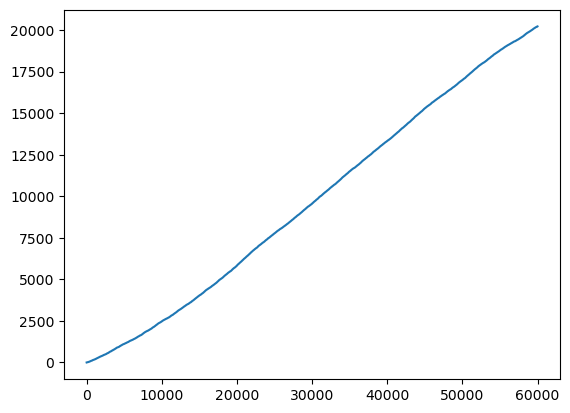

In [95]:
df_logs = pd.DataFrame(logs, columns=['round', 'interaction'])
df_logs.interaction.cumsum().plot()

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

PCA NO. Usar MCA. Se puede importar desde prince

In [127]:
agents_list = np.array(list(chain.from_iterable(agg_data)))
agents_list_str = list(map(lambda agent: "".join([str(trait) for trait in agent]), agents_list))

In [97]:
scaler = StandardScaler()
pca = PCA(n_components=2, random_state=42)

In [124]:
X = scaler.fit_transform(agents_list)
X = pca.fit_transform(X)

In [125]:
import plotly.graph_objects as go

In [105]:
from itertools import chain

In [139]:
data = go.Scatter(x=X[:, 0], y=X[:, 1], mode='markers', hovertext=agents_list_str, opacity=.5)
fig = go.Figure(data=data)
fig.show()